In [0]:
import numpy as np
import random
import copy
import math

In [0]:
#mock objectives:
def obj1(aa):
  return np.sum(np.sin(aa), axis = 0)

def obj2(bb):
  return np.sum(np.cos(bb), axis = 0)

def binh2d(aa):
  ret = []
  for i in range(len(aa)):
    ret.append(4*aa[i,0]**2 + 4*aa[i,1]**2)
  return np.array(ret)

def korn2d(aa):
  ret = []
  for i in range(len(aa)):
    ret.append((aa[i,0]-5)**2 + (aa[i,1]-5)**2)
  return np.array(ret) 

objectives = [binh2d, korn2d]

In [0]:
a = np.array([[1,2,3,4],[4,5,6,7]]).transpose()
print(a.shape)
b= np.array([1,2,3,4])
print(np.multiply(4, a[0]) + np.multiply(4, a[1]))
print(binh2d(a))
a[:,0] = binh2d(a)
print(a)

(4, 2)
[12 36]
[ 68 116 180 260]
[[ 68   4]
 [116   5]
 [180   6]
 [260   7]]


In [0]:
current_objectives = np.zeros((10,2))
print(current_objectives.shape)
positions = np.random.rand(10,5)
for i in range(len(objectives)):
      current_objectives[i] = objectives[i](positions)
      print(positions.shape)
      print(objectives[i](positions).shape)
print(current_objectives)
print(current_objectives.shape)

(10, 2)


ValueError: ignored

In [0]:
class Swarm:

  def __init__(self, size, dims, objectives):
    self.size = size #no of particles
    self.dims = dims #no of dimensions
    self.objectives = objectives #list of objective functions
    self.positions = np.zeros((size, dims)) #shape: size x dims
    self.velocities = np.zeros((size, dims)) #shape: size x dims
    self.fitnesses = np.zeros(size) #shape: size x 1
    self.diversity = np.zeros(size) #shape: size x 1
    self.convergence = np.zeros(size) #shape: size x 1

    self.current_objectives = np.zeros((size, len(objectives))) #shape: size x size(objectives)
    self.all_objectives = []#????
    self.sde = np.zeros((size, len(objectives))) #shape: size x size(objectives)
    self.sde_sum = np.zeros(size) #shape: size x size(objectives)
    self.best_positions = np.zeros((size, dims)) #shape: size x dims
    self.best_position_objectives = np.zeros((size, len(objectives))) #shape: size x 1
    self.alphas = np.ones(size) #shape: size x 1 ???
    self.betas = np.ones(size) #shape: size x 1 ???
    self.position_minima = np.zeros((size, dims))
    self.position_maxima = np.zeros((size, dims))
    self.velocity_minima = np.zeros((size, dims))
    self.velocity_maxima = np.zeros((size, dims))

  def init_swarm(self):
    self.positions = np.random.rand(self.size,self.dims)
    self.velocities = np.random.rand(self.size,self.dims)
    self.evaluate_objectives()
    self.evaluate_fitnesses()

  def init_swarm_values(self, positions, velocities):
    self.positions = positions
    self.velocities = velocities
    self.evaluate_objectives()
    self.evaluate_fitnesses()

  def normalization(self, objectives_no, objectives_min, objectives_max):
    for i in range(objectives_no):
      for p in range(len(self.positions)):
        self.current_objectives = (self.current_objectives - objectives_min[i])/(objectives_max[i]-objectives_min[i])

  def evaluate_objectives(self):
    #evaluate and set self.objectives
    #sets whole objectives array
    for i in range(len(self.objectives)):
      self.current_objectives[:,i] = self.objectives[i](self.positions)

  def set_best_positions(self):
    #sets individual best positions
    for i in range(self.size):
      if check_dominance(self.best_position_objectives[i], self.current_objectives[i]) == -1:
        self.best_positions[i] = self.positions[i]

  def calculate_sde(self):
    for i in range(len(self.objectives)):
      for p1 in range(len(self.positions)):
        sde = 0
        for p2 in range(len(self.positions)):
          if p1 != p2:
            sde = sde + (self.current_objectives[p1, i]-self.current_objectives[p2, i])**2
        self.sde[p1, i] = sde
    for p in range(len(self.positions)):
      self.sde_sum[p] = sum(self.sde[p])
      self.sde_sum[p] = math.sqrt(self.sde_sum[p])

  def calculate_normalized_diversity(self):
    self.calculate_sde()
    for p in range(len(self.positions)):
      self.diversity[p] = (self.sde_sum[p]-min(self.sde_sum))/(max(self.sde_sum)-min(self.sde_sum)+1)

  def calculate_convergence_distance(self):
    for p in range(len(self.positions)):
      dis = 0
      for i in range(len(self.objectives)):
        dis = dis + self.current_objectives[p, i]**2
      dis = math.sqrt(dis)
      self.convergence[p] = 1-(dis/math.sqrt(len(self.objectives)))

  def evaluate_fitnesses(self):
    objectives_min = self.get_min_objectives()
    objectives_max = self.get_max_objectives()
    self.normalization(len(self.objectives), objectives_min, objectives_max)
    
    self.calculate_normalized_diversity()
    self.calculate_convergence_distance()

    for p in range(self.size):
      self.fitnesses[p] = self.alphas[p] * self.diversity[p] + self.betas[p] * self.convergence[p]
      #self.fitnesses[p] = self.diversity[p] + self.convergence[p]

    #print(self.fitnesses)
    #print("Positions: ", self.positions)

  def update_velocities(self, archive):
    #equation 10, page 5
    #are lr different for each parrticle?
    #are random different for each particle
    global_best = archive.get_best_position()
    for i in range(self.dims):
      a = inertial_weight*self.velocities[:,i]
      b = lr_1 * random.uniform(0,1) * (self.best_positions[:,i] - self.positions[:,i])
      c = lr_2 * random.uniform(0,1) * (global_best[i] - self.positions[:,i])
      d = lr_3 * random.uniform(0,1) * (global_best[i] - self.best_positions[:,i])
      self.velocities[:,i] = a + b + c + d

  def update_positions(self):
    self.positions = self.positions + self.velocities
    pass

  def mutation(self, mutation_rate):
    for i in range(self.dims):
      if random.random() < mutation_rate: #position mutation
        self.positions[i] = self.positions[i] + np.random.uniform(-0.1, 0.1, self.dims)
      if random.random() < mutation_rate: #velocity mutation
        self.velocities[i] = self.velocities[i] + np.random.uniform(-0.1, 0.1, self.dims)

  def update_extrema(self):
    for i in range(self.positions.shape[1]):
      self.position_minima[i] = self.positions[:,i].min()
      self.position_maxima[i] = self.positions[:,i].max()
      self.velocity_minima[i] = self.velocities[:,i].min()
      self.velocity_maxima[i] = self.velocities[:,i].max()

  def get_min_objectives(self):
        return np.min(self.current_objectives, axis=0)

  def get_max_objectives(self):
        return np.max(self.current_objectives, axis=0)

  def reset_swarm(self):
    self.positions = np.array((0,0))

  def add_particle(self, position_velocity):
    #takes a tuple [position, velocity]
    self.positions.append(positions_velocity[0])
    self.velocities.append(positions_velocity[1])

In [0]:
#unit testing
lr_1, lr_2, lr_3 = 1, 1, 1
inertial_weight = 1
roj = Swarm(10, 5, objectives)
roj.evaluate_objectives()
roj.init_swarm()
roj.update_extrema()
roj.mutation(0.2)
print(roj.fitnesses)
print(roj.positions)

In [0]:
#unit testing
print(roj.velocities)
roj.update_velocities()
print(roj.velocities)

In [0]:
#unit testing
print(roj.positions)
roj.update_positions()
print(roj.positions)

In [0]:
def check_dominance(a, b):
  '''check Pareto dominance of two vectors of arbitrary lenght
    - return 1 if A dominates B
    - return -1 if B dominates A or are equal'''
  if len(a) != len(b):
    return "Error"
  for i in range(0, len(a)):
    if a[i] > b[i]:
      return -1
  for j in range(0, len(a)):
    if a[j] < b[j]:
      return 1
  return -1

#Archive

In [0]:
class Archive:
    def __init__(self, max_size, dims, objectives):
        self.max_size = max_size
        self.arch = Swarm(max_size, dims, objectives)
        self.arch.init_swarm()
            
    def archive_update(self, swarm):
      swarm_dominated = np.zeros(swarm.size, dtype=bool) #F if objective not dominated, T if dominated

      for i in range(swarm.size):
        arch_dominated = np.zeros(self.arch.size, dtype=bool) #F if objective not dominated, T if dominated
        for j in range(self.arch.size):
          flag = check_dominance(swarm.current_objectives[i,:], self.arch.current_objectives[j,:])
          if flag == 1:
            arch_dominated[j] = True
          elif flag == -1:
            swarm_dominated[i] = True
            break
        #delete dominated solutions from A
        arch_temp_positions = self.arch.positions[arch_dominated,...]
        arch_temp_velocities = self.arch.velocities[arch_dominated,...]
        if swarm_dominated[i] == False:
          arch_temp_positions.append(swarm.positions[i])
          arch_temp_velocities.append(swarm.velocities[i])
          if len(arch_temp_positions) > self.max_size:
            self.arch = Swarm(len(arch_temp_positions), dims, objectives)
            self.arch.init_swarm_values(arch_temp_positions, arch_temp_velocities)
            del_index = np.argmin(self.arch.fitnesses)
            result = np.delete(result, 1, axis=0)
            arch_temp_positions = np.delete(self.arch.positions, del_index, axis=0)
            arch_temp_velocities = np.delete(self.arch.velocities, del_index, axis=0)
            self.arch = Swarm(len(arch_temp_positions), dims, objectives)
            self.arch.init_swarm_values(arch_temp_positions, arch_temp_velocities)

    def get_best_position(self):
        '''Return  position of one randomly chosen particle from best 10% in current archive'''
        best_ind = np.argpartition(self.arch.fitnesses, -int(self.arch.fitnesses.size/10))[-int(self.arch.fitnesses.size/10):]
        choice = np.random.choice(best_ind, 1)
        return self.arch.positions[choice].transpose()
    
    def evaluate_fitnesses(self):
      self.arch.evaluate_fitnesses()

#Evolutionary search

In [0]:
def select_individual_by_tournament(swarm):
    fitnesses = swarm.fitnesses
    # Pick individuals for tournament
    fighter_1 = random.randint(0, swarm.size-1)
    fighter_2 = random.randint(0, swarm.size-1)
    
    # Get fitness score for each
    fighter_1_fitness = fitnesses[fighter_1]
    fighter_2_fitness = fitnesses[fighter_2]
    
    # Identify undividual with lowest fitness
    # Fighter 1 will win if score are equal
    if fighter_1_fitness <= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    
    # Return the chromosome of the winner
    return swarm.positions[winner, :], swarm.velocities[winner, :]

def breed_by_crossover(parent_1, parent_2):
    # Get length of chromosome
    chromosome_length = len(parent_1[0])
    
    # Pick crossover point, avoding ends of chromsome
    crossover_point = random.randint(1,chromosome_length-1)
    
    # Create children. np.hstack joins two arrays
    child_1 = np.hstack((parent_1[0][0:crossover_point], parent_2[0][crossover_point:])), np.hstack((parent_1[1][0:crossover_point], parent_2[1][crossover_point:]))
    
    child_2 = np.hstack((parent_2[0][0:crossover_point], parent_1[0][crossover_point:])), np.hstack((parent_2[1][0:crossover_point], parent_1[1][crossover_point:]))
    
    # Return children
    return child_1, child_2

def evolutionary_search(archive):
  swarm = archive.arch
  # Create an empty list for new population
  new_swarm = Swarm(swarm.size, swarm.dims, swarm.objectives)
  new_pos = []
  new_velo = []

  # Create new popualtion generating two children at a time
  #POSITION AND VELOCITY
  for i in range(int(swarm.size/2)):
      parent_1 = select_individual_by_tournament(swarm)
      parent_2 = select_individual_by_tournament(swarm)
      child_1, child_2 = breed_by_crossover(parent_1, parent_2)
      new_pos.append(child_1[0])
      new_pos.append(child_2[0])
      new_velo.append(child_1[1])
      new_velo.append(child_2[1])

  new_swarm.positions = np.array(new_pos)
  new_swarm.velocities = np.array(new_velo)
  
  # Replace the old population with the new one
  swarm = new_swarm
  swarm.evaluate_objectives()
  swarm.evaluate_fitnesses()
  # Apply mutation
  mutation_rate = 0.5
  swarm.mutation(mutation_rate)
  
  return swarm

In [0]:
old = copy.deepcopy(roj.positions)
#print(roj.positions)
roj = evolutionary_search(roj)
np.set_printoptions(3)
print(old - roj.positions)

#Initialization

In [0]:
number_of_particles = 10
no_dims = 2

swarm = Swarm(number_of_particles, no_dims, objectives)
swarm.init_swarm()

max_archive_size = 12
archive = Archive(max_archive_size, no_dims, objectives)

swarm.evaluate_objectives()
swarm.set_best_positions()
swarm.current_objectives

array([[ 2.81923858, 41.78918671],
       [ 1.67133179, 41.34164454],
       [ 1.02994875, 43.46710959],
       [ 4.19398559, 36.60968833],
       [ 0.87134539, 44.81310083],
       [ 0.53640972, 44.97422915],
       [ 1.59644449, 41.68376784],
       [ 0.07945262, 48.03790315],
       [ 2.92357929, 38.80633712],
       [ 2.10151625, 40.31892246]])

Initialization part 2 - archive

In [0]:
archive.archive_update(swarm)
archive.evaluate_fitnesses()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


Main loop

In [0]:
import time
import matplotlib
import matplotlib.pyplot as plt

max_iter = 100
i = 0
inertial_weight = 1
lr_1 = 1
lr_2 = 1
lr_3 = 1
swarm = Swarm(10,2,objectives)

then = time.time()
fitnesses = []
trace = []

while i < max_iter:
  swarm.update_velocities(archive)
  swarm.update_positions()
  swarm.evaluate_objectives()
  swarm.set_best_positions()
  archive.archive_update(swarm) #BFE is here
  #evolutionary search stratedy is applied on archive to get a new swarm - probably one step of some EA - write some function for it 
  swarm = evolutionary_search(archive) # or archive.evolutionary_search() ¯\_(ツ)_/¯
  swarm.evaluate_objectives()
  swarm.set_best_positions()
  archive.archive_update(swarm) #BFE is here'''
  fitnesses.append(min(swarm.fitnesses))
  trace.append(swarm.positions[np.argmin(swarm.fitnesses)])
  i = i + 2
  
#print(swarm.positions)
print(swarm.positions[0,:])

now = time.time()
print(now-then)
print("end")



[0.22437957 0.88120923]
0.08300375938415527
end


#Visualisation

[array([0.12785875, 0.99790477]), array([0.5318445 , 0.66863595]), array([0.70176697, 0.64354619]), array([0.47399132, 0.53455247]), array([0.42566911, 0.88120923]), array([0.20537044, 0.53455247]), array([0.42566911, 0.20592984]), array([0.2531349 , 0.91143721]), array([0.28825115, 1.02151726]), array([0.47399132, 0.58643295]), array([0.39793019, 0.7408702 ]), array([0.06114299, 0.18424176]), array([0.39406461, 0.0318465 ]), array([0.37096791, 0.52753069]), array([0.68053481, 0.66744925]), array([0.61941603, 0.19176556]), array([0.54716242, 0.88120923]), array([0.22437957, 0.91143721]), array([0.53027457, 0.6274481 ]), array([0.47399132, 0.58643295]), array([0.3763516 , 0.64354619]), array([0.60341353, 0.47806842]), array([0.5406386, 0.9438252]), array([0.29477513, 0.89540834]), array([0.2531349 , 0.58643295]), array([0.70176697, 0.53405719]), array([0.20345409, 0.61237692]), array([0.60679813, 0.93356682]), array([0.42566911, 0.64354619]), array([0.41544062, 0.52810209]), array([0.50

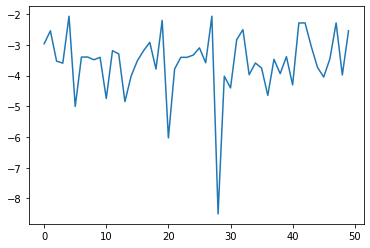

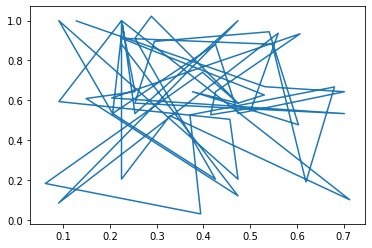

In [0]:
plt.figure(0)
plt.plot(fitnesses)
print(trace)
plt.figure(1)
trace = np.array(trace)
plt.plot(*trace.T)


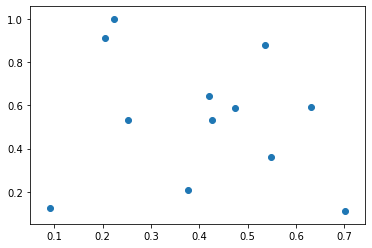

In [0]:
plt.scatter(archive.arch.positions[:,0], archive.arch.positions[:,1])